# <p style = text-align: center>Estudo de Caso - Modelo preditivo para cancelamento de reservas de Hotel

<a id = '0'></a>
### Conteudo:
* [1. Objetivo do modelo](#1.0)
* [2. Expectativas iniciais](#2.0)
* [3. Importacao e exploracao de dados](#3.0)
    * [3.1 Importacao das bibliotecas](#3.1)
    * [3.2 Importacao da base de dados](#3.2)
    * [3.3 Entendimento inicial dos dados](#3.3)
    * [3.4 Analise exploratoria dos dados](#3.4)
    * [3.5 Tratamento de outliers](#3.5)
        * [3.5.1 Metodo de Turkey para tratamento de outliers de colunas numericas](#3.5.1)
        * [3.5.2 Colunas com texto/categoricas](#3.5.2)        
* [4. Modelo de previsao](#4.0)
    * [4.1 Estruturando o modelo](#4.1)
    * [4.2 Gerando a previsao](#4.2)
    * [4.3 Avaliacao de importancia das features](#4.3)
* [5. Consideracoes finais](#5.0)

<a id='1.0'></a>
### 1.  Objetivo do Modelo

Gerar valor para o time comercial a partir da criacao de um modelo capaz de prever se uma reserva de hotel sera cancelada ou nao pelo cliente.

Entende-se que este modelo devera trazer beneficios aos processos da equipe comercial, trazendo mais eficiencia no direcionamento de esforcos.

<a id = '2.0'></a>
### 2. Expectativas iniciais

A partir da leitura do artigo "Hotel booking demand datasets", que traz a descricao da base de dados e de todas as suas variaveis, segue abaixo algumas expectativas/pensamentos iniciais da equipe de Machine Learning:
- Acredita-se que quanto mais dias um pedido de reserva fica na lista de espera para ser aprovado, maior a probabilidade dele ser cancelado visto que daria mais tempo para o cliente mudar de ideia.
- Intuitivamente, espera-se tambem que um cliente com historico de cancelamentos tenha a tendencia de efetuar novos cancelamentos.
- Em contrapartida ao ponto anterior, pode ser que clientes antigos tenham menor tendencia em cancelar suas reservas visto que conhecem os processos de agendamento e foram fidelizados por algum motivo.
- Para aplicacao do modelo no Hurb, entende-se que variaveis como o "range" de datas escolhidas para a reserva e o nao entendimento do Regulamento de Hoteis (por parte do cliente) poderiam ser variaveis importantes e que nao temos na base de dados.

<a id = '3.0'></a>
### 3. Importacao e exploracao de dados

<a id = '3.1'></a>
#### 3.1 Importacao das Bibliotecas

In [1]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix

<a id = '3.2'></a>
#### 3.2 Importacao da Base de Dados

In [2]:
df = pd.read_csv("hotel_bookings.csv")

# Primeira visualizacao dos dados
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


<a id = '3.3'></a>
#### 3.3 Entendimento inicial dos dados

In [3]:
# Dados estatisticos de cada coluna do dataframe
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


A partir da contagem de dados de cada coluna ("count"), percebe-se que as colunas "agent" e "company" nao possuem todas as linhas preenchidas. Provavel que esses campos nao sejam aplicaveis para todas as linhas.

In [4]:
# Print da taxa de valores vazios/nulos por coluna
print(df.isnull().sum()/len(df))

hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
arrival_date_year                 0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
meal                              0.000000
country                           0.004087
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
agent      

Conforme verificado anteriormente, as colunas "company" e "agent" possuem muitos dados faltantes (mais de 10% do total). Portanto, sera feita a retirada dessas colunas para nao atrapalhar a previsao do modelo.

As colunas "country" e "children" tambem possuem linhas vazias, porem em menor quantidade (menor que 1%). Neste caso, essas linhas serao preenchidas com os valores mais frequentes de cada coluna: "PRT" e "0", respectivamente.

In [5]:
# Drop das colunas "agent" e "company"
df.drop(["agent", "company"], axis = 'columns', inplace = True)

In [6]:
# Preenchendo valores em branco das colunas "contry" e "children" com o valor que mais se repete em cada campo
df['country'] = df['country'].fillna('PRT')
df['children'] = df['children'].fillna(0)

print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [7]:
# Verificando o tipo de dado de cada coluna
print(df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list              

In [8]:
# Ajustando o tipo de dado da coluna "children" para Inteiros
df['children'] = df['children'].astype(np.int64)

In [9]:
# Convertendo a coluna de meses para Inteiros (Jan = 1, Fev = 2, ...)
dt = df['arrival_date_month'].str[0:3]
numero_mes = np.zeros(len(dt))
for i in range (0, len(dt)):
    dt[i] = datetime.strptime(dt[i], "%b")
    numero_mes[i] = dt[i].month
    
# Transformando os dados de mes em inteiro
numero_mes = pd.DataFrame(numero_mes).astype(int)

# Unindo as colunas de data em uma unica coluna
df['data_chegada'] = df['arrival_date_year'].map(str) + '-' + numero_mes[0].map(str) + '-' + df['arrival_date_day_of_month'].map(str)

In [10]:
# Drop das antigas colunas referentes a data
df = df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_week_number'], axis = 1)

Sera assumido que as reservas de hotel que possuem 0 adultos sao devido a erro de registro no sistema, visto que criancas e bebes nao reservariam um quarto de hotel sozinhas.

In [11]:
# Eliminando linhas com valor 0 na coluna "adulto"
print(df.shape)
erro_adulto = df.adults == 0
df = df[~erro_adulto]
print(df.shape)

df.head()

(119390, 27)
(118987, 27)


,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,data_chegada
0,Resort Hotel,0,342,0,0,2,0,0,BB,PRT,...,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
1,Resort Hotel,0,737,0,0,2,0,0,BB,PRT,...,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
2,Resort Hotel,0,7,0,1,1,0,0,BB,GBR,...,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
3,Resort Hotel,0,13,0,1,1,0,0,BB,GBR,...,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
4,Resort Hotel,0,14,0,2,2,0,0,BB,GBR,...,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-7-1


<a id = '3.4'></a>
#### 3.4 Analise exploratoria de dados

A etapa de exploracao de dados e importante para aprender os padroes de comportamento das features e, principalmente, como elas se relacionam com a nossa variavel target ("is_canceled").

Nesta etapa, os seguintes pontos serao seguidos:
1. Verificar correlacao entre as features numericas.
2. Entender relacao que certas variaveis categoricas possuem com a variavel target.
3. Confirmar se todas as features que temos realmente fazem sentido para o modelo. Caso contrario, pode ser necessario excluir para dar maior eficiencia ao modelo.

<AxesSubplot:>

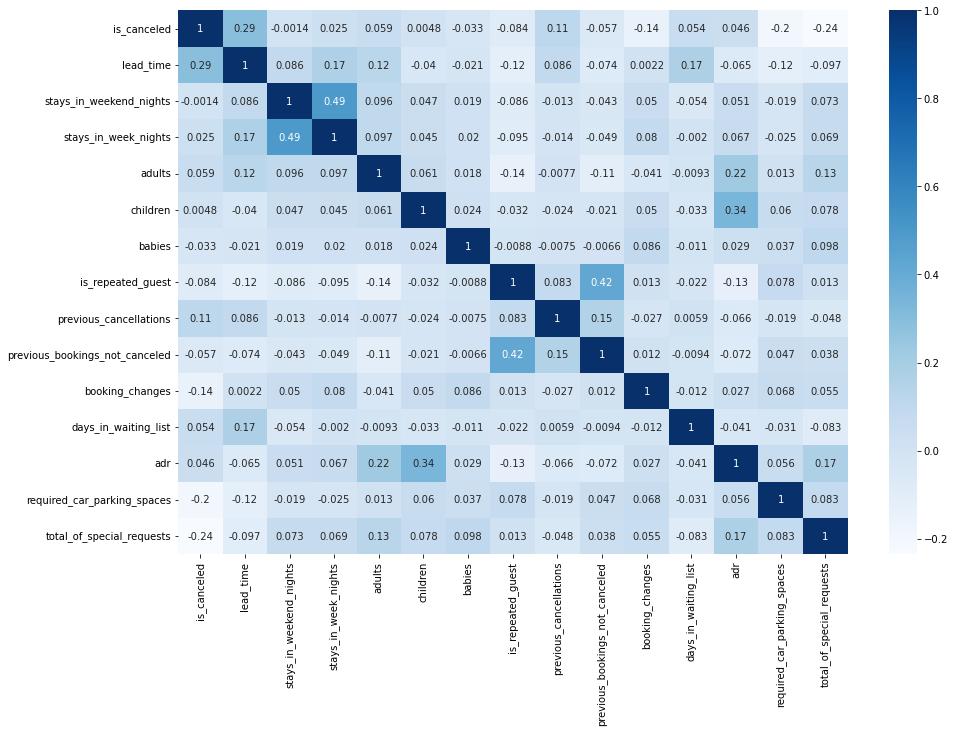

In [12]:
# Mapa de calor com correlacao entre todas as variaveis
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True, cmap = 'Blues')

In [13]:
# Coeficiente de correlacao da variavel target 'is_canceled' com o restante das features
correlacao = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlacao

is_canceled                       1.000000
lead_time                         0.292983
total_of_special_requests         0.235262
required_car_parking_spaces       0.195863
booking_changes                   0.144863
previous_cancellations            0.110222
is_repeated_guest                 0.083797
adults                            0.058891
previous_bookings_not_canceled    0.057413
days_in_waiting_list              0.054357
adr                               0.046460
babies                            0.032620
stays_in_week_nights              0.025348
children                          0.004837
stays_in_weekend_nights           0.001388
Name: is_canceled, dtype: float64

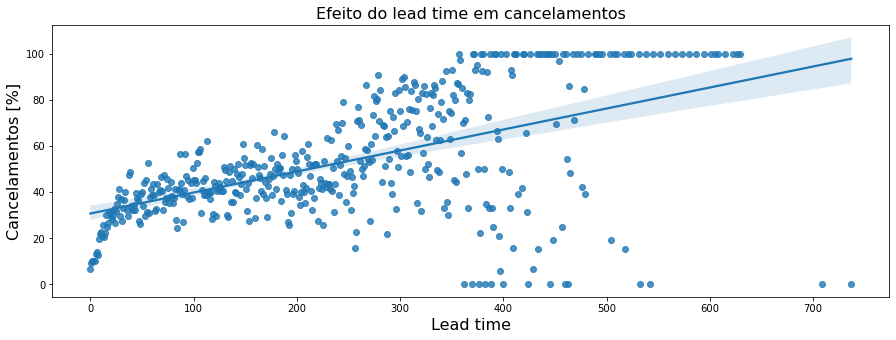

In [14]:
# Efeito do lead time em cancelamentos
lead_time_cancel = df.groupby("lead_time")['is_canceled'].describe()

# grafico
plt.figure(figsize=(15, 5))
sns.regplot(x=lead_time_cancel.index, y=lead_time_cancel["mean"].values * 100)
plt.title("Efeito do lead time em cancelamentos", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelamentos [%]", fontsize=16)
plt.show()

A partir do mapa de calor e possivel ter **maior entendimento sobre como as variaveis se comportam entre si**.

Um insight retirado daqui, por exemplo, e que **a feature com maior grau de relacao com o fato de uma reserva ser cancelada ou nao e a de "lead_time"**, ou seja, quanto maior o tempo existente entre a reserva do hotel ate a data de chegada no mesmo, maior a probabilidade de haver cancelamento.

No topico "Expectativas Inicias" desta documentacao, tambem foi pontuado o historico de cancelamentos do cliente (coluna "previous_cancellations" no caso desse dataset) como um possivel fator significativo. Olhando a correlacao, e possivel verificar que essa relacao realmente e valida, apresentando um grau de relacao de 11% com a variavel target.

Se o mapa de calor apresentasse colunas com correlacao forte (proximo de 1, por exemplo), provavelmente seria feita a exclusao de uma delas para nao enviesar o resultado do modelo.

Por outro lado, deve-se analisar com cuidado a utilidade de colunas com correlacao fraca (proximo de 0) e, se for o caso, as mesmas devem ser excluidas.

Colunas a serem retiradas do modelo:
- hotel: Como o estudo sera utilizado pela equipe comercial do Hurb, esta coluna sera retirada visto que o modelo deve ser aplicavel para todos os hoteis do catalogo.
- country: Por se tratar de hoteis Portugueses, nao temos um numero significativo de brasileiros registrados. Alem disso, assim como ocorre para a coluna 'hotel', manter a coluna 'country' compromete o fator de "generalizacao" do modelo.
- assigned_room_type: Pois ja existe a coluna "reserved_room_type", que e similar, e que nos retorna o quarto que de fato foi reservado.
- days_in_waiting_list: a maior parte dos dados dessa coluna sao 0 (poucos dias de espera). Alem disso, acredita-se que o 'lead time' ja seja uma feature mais efetiva para duracao de processo.
- reservation_status: tem funcao similar a variavel target.
- reservation_status_date: como a coluna "reservation_status" sera excluida, esta coluna tambem perde seu valor.

OBS.: Foi considerada a concatenacao entre os valores das colunas 'children' e 'babies' nesse processo de feature engineering, visto que se avaliou uma possivel dificuldade do processo em diferenciar criancas de bebes. Entretanto, a coluna resultante dessa soma apresentou um resultado ruim de correlacao com a variavel target.

In [15]:
# Colunas a serem retiradas
colunas = ['hotel','country', 'assigned_room_type', 'days_in_waiting_list', 'reservation_status', 'reservation_status_date']
df.drop(colunas, axis = 1, inplace = True)

df.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,data_chegada
0,0,342,0,0,2,0,0,BB,Direct,Direct,...,0,0,C,3,No Deposit,Transient,0.0,0,0,2015-7-1
1,0,737,0,0,2,0,0,BB,Direct,Direct,...,0,0,C,4,No Deposit,Transient,0.0,0,0,2015-7-1
2,0,7,0,1,1,0,0,BB,Direct,Direct,...,0,0,A,0,No Deposit,Transient,75.0,0,0,2015-7-1
3,0,13,0,1,1,0,0,BB,Corporate,Corporate,...,0,0,A,0,No Deposit,Transient,75.0,0,0,2015-7-1
4,0,14,0,2,2,0,0,BB,Online TA,TA/TO,...,0,0,A,0,No Deposit,Transient,98.0,0,1,2015-7-1


Segue analise de algumas variaveis categoricas com a variavel target:

C:\Users\joaov\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


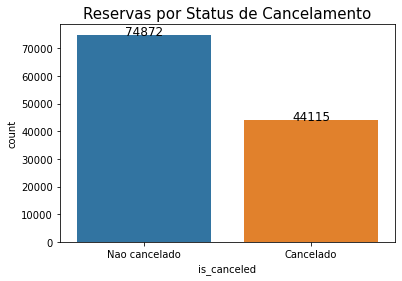

In [16]:
# Proporcao de reservas canceladas x nao canceladas
canceled_data = df['is_canceled']
plot = sns.countplot(canceled_data)
plt.title('Reservas por Status de Cancelamento', size=15)
ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['Nao cancelado', 'Cancelado'])
for i in plot.patches:
    plot.annotate(i.get_height(),
                 (i.get_x() + i.get_width() / 2, i.get_height()),
                 ha = 'center', va = 'baseline', fontsize=12,
                 )

plt.show()

Os hoteis da base de dados apresentaram uma taxa de cancelamentos significativa, de 37% entre 2015 e 2017. Esse fato pode ter dificultado a operacao dos hoteis, por exemplo, no momento de dimensionar a logistica de compra de comidas para as refeicoes.

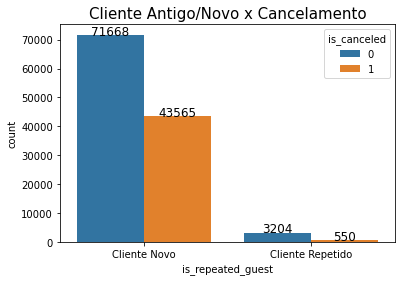

In [17]:
# Comportamento de clientes antigos com cancelamentos de reservas
plot = sns.countplot(data=df, x = 'is_repeated_guest', hue='is_canceled')
plt.title('Cliente Antigo/Novo x Cancelamento', size=15)
ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['Cliente Novo', 'Cliente Repetido'])

for i in plot.patches:
    plot.annotate(i.get_height(),
                 (i.get_x() + i.get_width() / 2, i.get_height()),
                 ha = 'center', va = 'baseline', fontsize=12,
                 )

Clientes repetidos tem uma tendencia menor em cancelar uma reserva (15%) quando comparado com novos clientes (37,5%).

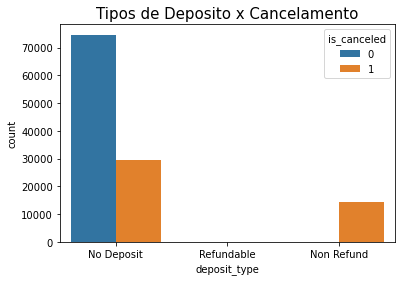

In [18]:
sns.countplot(data = df, x = 'deposit_type',hue='is_canceled')
plt.title('Tipos de Deposito x Cancelamento', size=15)

plt.show()

A informacao sobre a existencia ou nao de um deposito para garantir a reserva parece ser bastante relevante para o modelo.

Quase a totalidade de casos de 'Non Refund' (quando feito um deposito no valor total do custo de estadia) possui a tendencia em ser cancelado.

<a id = '3.5'></a>
#### 3.5 Tratamento de Outliers

<a id = '3.5.1'></a>
##### 3.5.1 Metodo de Turkey para encontrar e tratar outliers de colunas numericas

A partir do metodo de Turkey, serao encontrados os limites inferiores e superiores da distribuicao de dados das features. Depois sera feita uma analise em cima dos dados que estiverem abaixo do limite inferior (𝐿𝑖𝑛𝑓 = 𝑄1 − (1.5 ∗ 𝐼𝑄𝑅)) ou acima do limite superior (𝐿𝑠𝑢𝑝 = 𝑄3 + (1.5 ∗ 𝐼𝑄𝑅)) e, se for o caso, os outliers serao excluidos.

In [19]:
# Funcao para definir os limites de uma coluna
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude # retornaremos o limite inferior e superior

# Funcao que vai pegar os limites da funcao anterior para excluir os outliers.
# Alem disso, vai retornar a quantidade de linhas removidas pois se a quantidade for muito grande, pode afetar o modelo.
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup) , :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [20]:
# Funcao para aplicar o boxplot e entender o comportamento das colunas
def diagrama_caixa(coluna):
    fig, (ax1,ax2) = plt.subplots(1,2) # ax1 -> eixo do 1º grafico. ax2 -> eixo do 2º grafico
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

Tratamento das colunas com valores:
- lead_time
- stays_in_weekend_nights
- stays_in_week_nights
- adults
- children
- babies
- previous_cancellations
- previous_bookings_not_canceled
- booking_changes
- adr
- total_of_special_requests

C:\Users\joaov\AppData\Local\Temp/ipykernel_25320/3239904395.py:6: UserWarning: Attempting to set identical left == right == 2.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_25320/3239904395.py:6: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_25320/3239904395.py:6: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_25320/3239904395.py:6: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_25320/3239904395.py:6: UserWarning: Attempting to set identical 

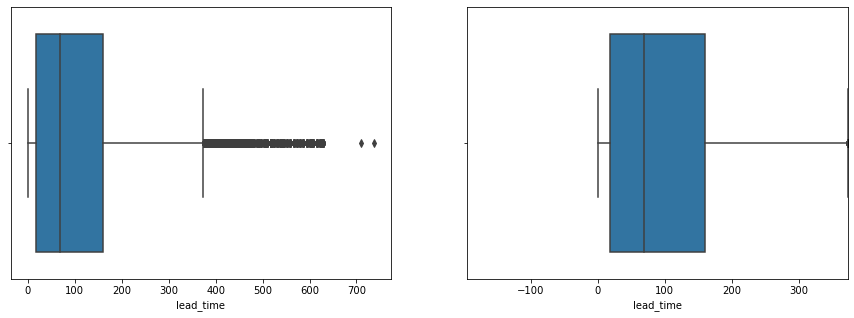

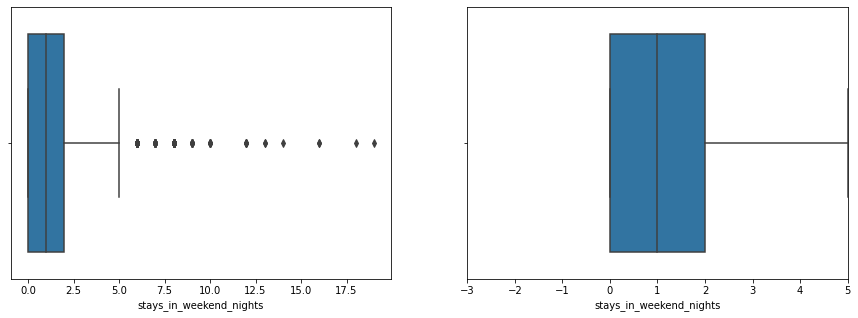

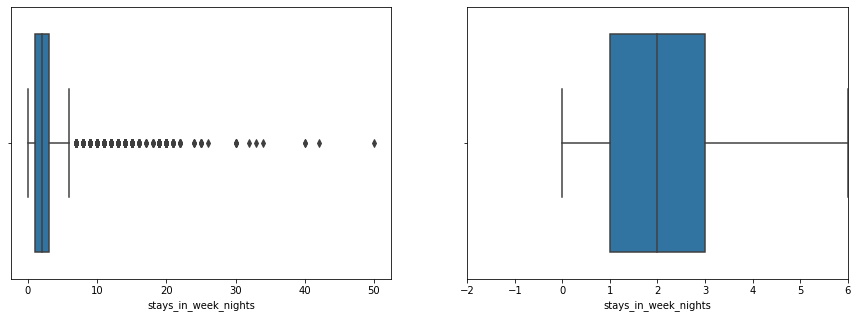

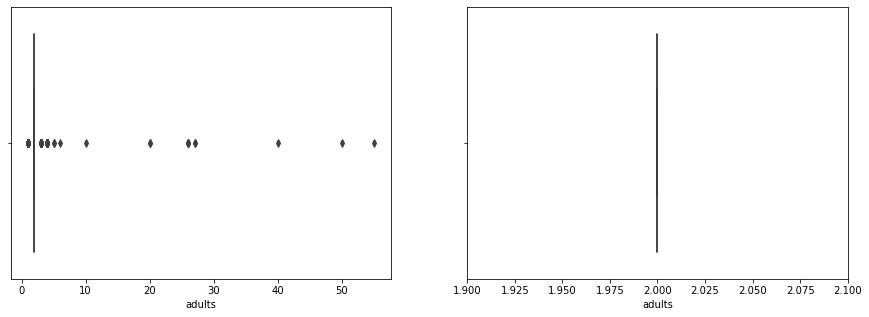

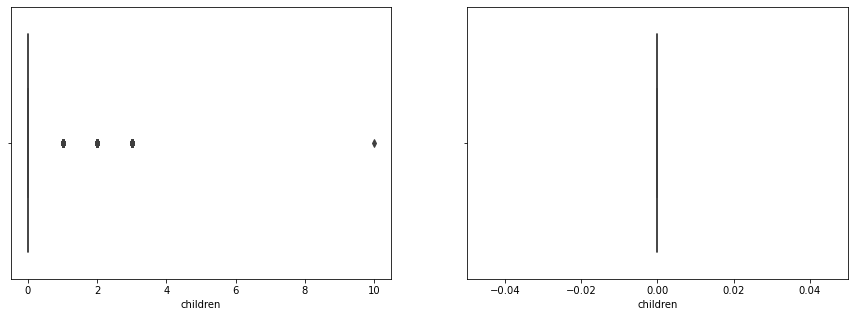

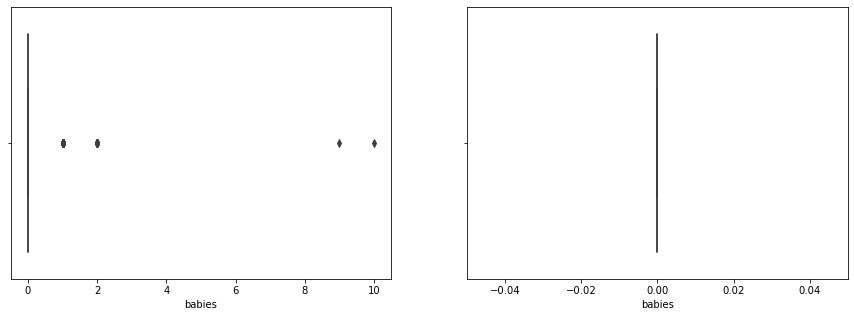

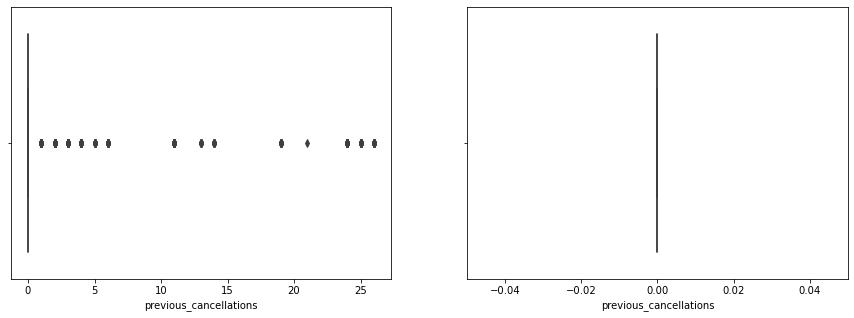

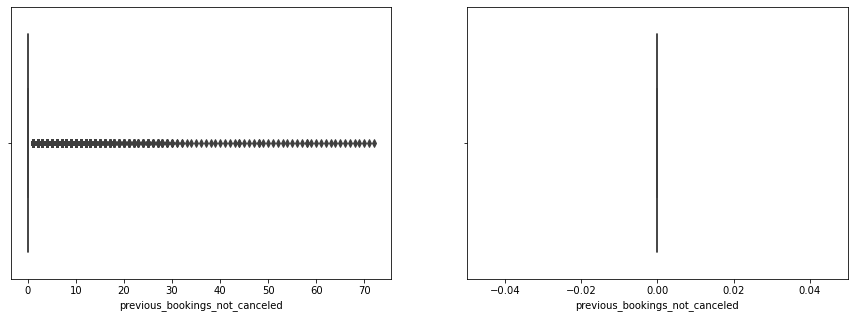

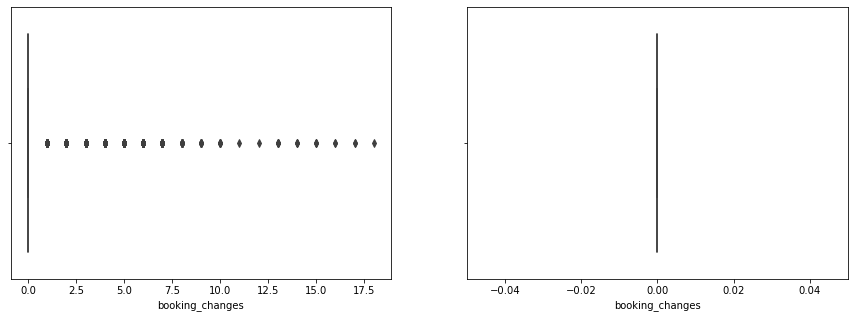

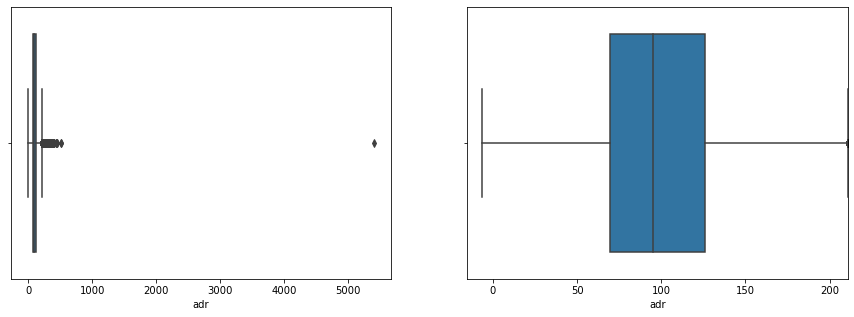

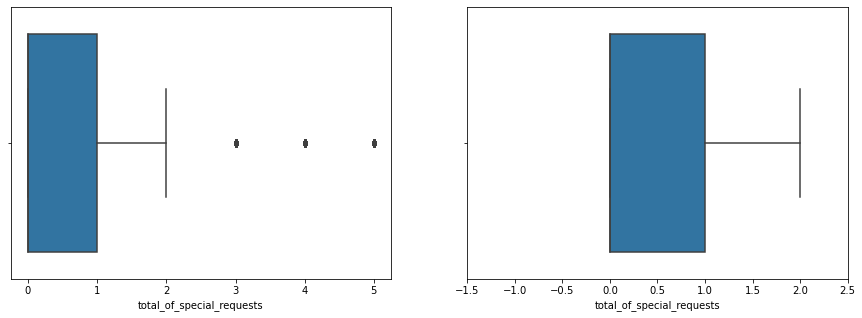

In [21]:
col_valores = ['lead_time','stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'total_of_special_requests']

for i in col_valores:
    diagrama_caixa(df[i])

A partir dos graficos de boxplot acima, fica possivel notar que existem **colunas com limite inferior e superior iguais**: adults, children, babies, previous_cancelations, previous_bookings_not_canceled, booking_changes.

A retirada de outliers dessas colunas faria com que elas perdessem o sentido no modelo, visto que ter apenas um valor na coluna apenas enviesaria a previsao. Em contrapartida, tambem nao pretendo excluir essas colunas visto que todas apresentam correlacao significativa com a variavel target. Assim, deixarei essas colunas intactas.

Quanto as outras colunas, todas possuem limites inferiores abaixo de 0. Como tais colunas possuem valores positivos, serao apenas retirados outliers acima do limite superior.

In [22]:
# Colunas com limite inferior e superior iguais

print("Limite da coluna 'adults':{}".format(limites(df['adults'])))
print("Limite da coluna 'children': {}".format(limites(df['children'])))
print("Limite da coluna 'babies': {}".format(limites(df['babies'])))
print("Limite da coluna 'previous_cancellations': {}".format(limites(df['previous_cancellations'])))
print("Limite da coluna 'previous_bookings_not_canceled': {}".format(limites(df['previous_bookings_not_canceled'])))
print("Limite da coluna 'booking_changes': {}".format(limites(df['booking_changes'])))

Limite da coluna 'adults':(2.0, 2.0)
Limite da coluna 'children': (0.0, 0.0)
Limite da coluna 'babies': (0.0, 0.0)
Limite da coluna 'previous_cancellations': (0.0, 0.0)
Limite da coluna 'previous_bookings_not_canceled': (0.0, 0.0)
Limite da coluna 'booking_changes': (0.0, 0.0)


In [23]:
# Limites das outras colunas

print("Limite da coluna 'lead_time':{}".format(limites(df['lead_time'])))
print("Limite da coluna 'stays_in_weekend_nights':{}".format(limites(df['stays_in_weekend_nights'])))
print("Limite da coluna 'stays_in_week_nights':{}".format(limites(df['stays_in_week_nights'])))
print("Limite da coluna 'adr':{}".format(limites(df['adr'])))
print("Limite da coluna 'total_of_special_requests':{}".format(limites(df['total_of_special_requests'])))

Limite da coluna 'lead_time':(-195.0, 373.0)
Limite da coluna 'stays_in_weekend_nights':(-3.0, 5.0)
Limite da coluna 'stays_in_week_nights':(-2.0, 6.0)
Limite da coluna 'adr':(-15.25, 210.75)
Limite da coluna 'total_of_special_requests':(-1.5, 2.5)


In [24]:
# Retirando outliers da coluna 'lead_time'
df, qtde_linhas_removidas = excluir_outliers(df,'lead_time')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3003 linhas removidas


In [25]:
# Retirando outliers da coluna 'stays_in_weekend_nights'
df, qtde_linhas_removidas = excluir_outliers(df,'stays_in_weekend_nights')
print('{} linhas removidas'.format(qtde_linhas_removidas))

255 linhas removidas


In [26]:
# Retirando outliers da coluna 'stays_in_week_nights'
df, qtde_linhas_removidas = excluir_outliers(df,'stays_in_week_nights')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3039 linhas removidas


In [27]:
# Retirando outliers da coluna 'adr'
df, qtde_linhas_removidas = excluir_outliers(df,'adr')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3556 linhas removidas


In [28]:
# Retirando outliers da coluna 'total_of_special_requests'
df, qtde_linhas_removidas = excluir_outliers(df,'total_of_special_requests')
print('{} linhas removidas'.format(qtde_linhas_removidas))

2537 linhas removidas


In [29]:
# Nova estrutura de linhas e colunas do dataframe
df.shape

(106597, 21)

<a id = '3.5.2'></a>
##### 3.5.2 Colunas com texto/categoricas

In [30]:
# Quantidade de categorias existentes por coluna
a = df.select_dtypes(object).columns
for i in a:
    print (i, df[i].nunique())

meal 5
market_segment 8
distribution_channel 5
reserved_room_type 9
deposit_type 3
customer_type 4
data_chegada 793


In [31]:
# Divindo a coluna de 'data_chegada' em ano, mes e dia.
# Sera feito isso para diminuir o peso de uma unica feature, reduzindo a complexidade do modelo.

df['data_chegada'] = pd.to_datetime(df['data_chegada'])

df['ano_chegada'] = df['data_chegada'].dt.year
df['mes_chegada'] = df['data_chegada'].dt.month
df['dia_chegada'] = df['data_chegada'].dt.day

df.drop(['data_chegada'], axis=1, inplace=True)

In [32]:
# Usando o LabelEncoder para padronizar a escala de numeros utilizada nas colunas de data
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df['ano_chegada'] = le.fit_transform(df['ano_chegada'])
df['mes_chegada'] = le.fit_transform(df['mes_chegada'])
df['dia_chegada'] = le.fit_transform(df['dia_chegada'])

In [33]:
# Colunas de categoria do dataset
txt_cols = df.select_dtypes(object).columns

for i in txt_cols:
    print(f"{i}: {df[i].unique()}\n")

meal: ['BB' 'FB' 'HB' 'SC' 'Undefined']

market_segment: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']

distribution_channel: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

reserved_room_type: ['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']

deposit_type: ['No Deposit' 'Refundable' 'Non Refund']

customer_type: ['Transient' 'Contract' 'Transient-Party' 'Group']



Para codificar essas colunas de texto, sera usado o metodo do ONE HOT ENCODER, que se assimila ao LabelEncoder, porem divide as colunas em varias outras que representam suas categorias. Essas colunas serao preenchidas apenas com 0 ou 1.

In [34]:
# Criando uma copia do dataframe original
df_encod = df.copy()

# Encoding a partir do metodo de variaveis dummies
df_encod = pd.get_dummies(data = df_encod, columns = txt_cols)
df_encod.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,7,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,13,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,14,0,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0,14,0,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


<a id = '4.0'></a>
### 4. Modelo de Previsao

<a id = '4.1'></a>
#### 4.1 Estruturando o Modelo

In [35]:
# Extraindo a variavel target do modelo
X = df_encod.drop('is_canceled', axis = 1)
y = df_encod['is_canceled']

X.shape, y.shape

((106597, 50), (106597,))

In [36]:
# Separando conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

Os dados apresentam uma diferenca significante de escala entre si. Para evitar que uma feature seja predominante sobre outra, aplicarei uma tecnica de Feature Scalling chamada Standardization (Normalizacao).

Neste metodo, os dados serao redimensionados, garantindo que eles fiquem em formato de curva Gaussiana.

In [37]:
# Feature Scalling
scaler = StandardScaler().fit(df[col_valores])
scaler.transform(df[col_valores])
df[col_valores] = scaler.transform(df[col_valores])

O modelo tem como objetivo prever se uma reserva sera ou nao cancelada.

Portanto, os algoritmos de machine learning a serem utilizados sao:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

In [38]:
modelo_lr = LogisticRegression()
modelo_rf = RandomForestClassifier()
modelo_dt = DecisionTreeClassifier()
modelo_xgb = XGBClassifier()

modelos = {'Logistic Regression': modelo_lr,
          'Random Forest': modelo_rf,
          'Decision Tree': modelo_dt,
          'XGBoost': modelo_xgb}

<a id = '4.2'></a>
#### 4.2 Gerando a previsao

Ao passo que todos os 4 algoritmos sao treinados e testados, eles tambem serao avaliados em dois parametros:
- Accuracy Score: precisao do modelo em acertar a previsao (previsao == y_test)
- Confusion Matrix: uma matriz que mostra a quantidade de previsoes que retornaram verdadeiro positivo/negativo e falso positivo/negativo.

In [39]:
for nome_modelo, modelo in modelos.items():
    # treinar/fit:
    modelo.fit(X_train, y_train)
    # testar/predict:
    previsao = modelo.predict(X_test)
    acc = accuracy_score(y_test, previsao)
    conf = confusion_matrix(y_test, previsao)
    print(f"Precisao do {nome_modelo}: {acc}")
    print(f"Confusion Matrix {nome_modelo}: \n{conf}\n")

C:\Users\joaov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precisao do Logistic Regression: 0.7984615384615384
Confusion Matrix Logistic Regression: 
[[15646  1184]
 [ 4187  5633]]

Precisao do Random Forest: 0.8617636022514071
Confusion Matrix Random Forest: 
[[15679  1151]
 [ 2533  7287]]

Precisao do Decision Tree: 0.8222138836772983
Confusion Matrix Decision Tree: 
[[14447  2383]
 [ 2355  7465]]

Precisao do XGBoost: 0.8383114446529081
Confusion Matrix XGBoost: 
[[15590  1240]
 [ 3069  6751]]



O modelo com melhor nota de precisao foi o Random Forest, com cerca de 86% de accuracy score.

Para efeito de melhor visualizacao, segue um plot exemplo de arvore de decisao feita pelo Random Forest. Serao plotadas apenas 3 camadas da arvore por conta da quantidade de features existentes no modelo.

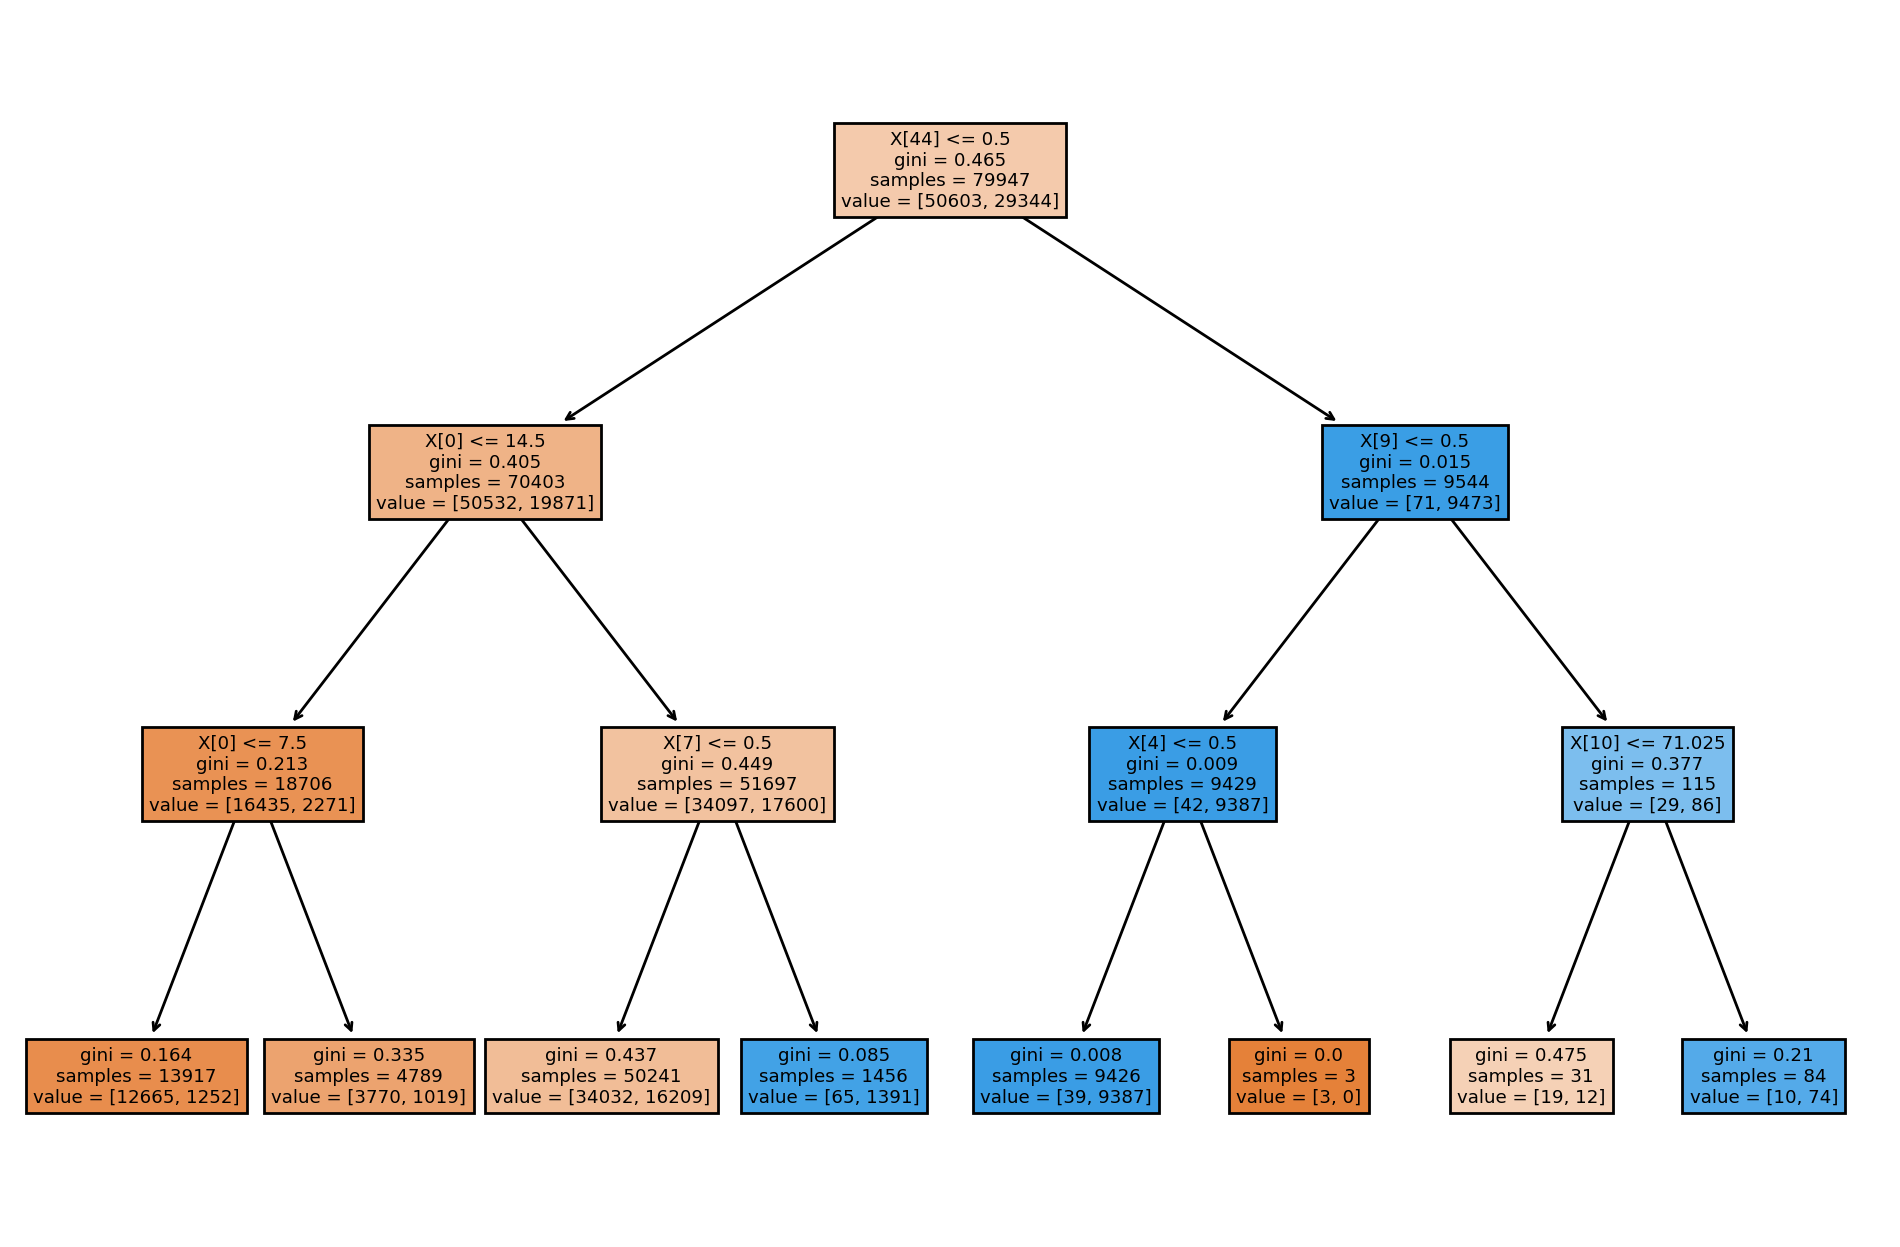

In [40]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8), dpi=200)

pruned_dtc = DecisionTreeClassifier(max_depth=3)
pruned_dtc.fit(X_train, y_train)
y_pred_dtc = pruned_dtc.predict(X_test)

plot_tree(pruned_dtc, filled = True);

<a id='4.3'></a>
#### 4.3 Avaliacao de importancia das features

Com a funcao **feature_importances_** fica possivel avaliar a utilidade de cada feature do modelo em prever a variavel target.

Esta avaliacao sera um passo importante para o modelo pois fornecera insights sobre os dados e o modelo que se tem em maos.

Dependendo do resultado, deve-se retornar para a etapa de feature engineering, e reduzir variaveis que nao possuem tanta importancia, em prol de obter uma maior eficiencia ao rodar o modelo.

,0
lead_time,0.165522
adr,0.114217
deposit_type_Non Refund,0.102448
dia_chegada,0.089001
deposit_type_No Deposit,0.071888
mes_chegada,0.058923
total_of_special_requests,0.054459
stays_in_week_nights,0.045892
previous_cancellations,0.041662
stays_in_weekend_nights,0.028568


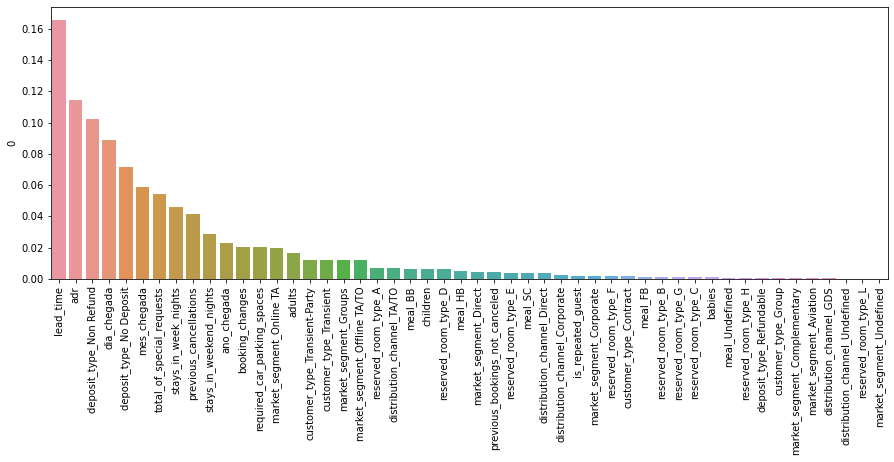

In [41]:
importancia_features = pd.DataFrame(modelo_rf.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

Certas features, como era esperado, tiveram importancia relevante no modelo, como: lead time, adr e o tipo de deposito.

Por outro lado, existem features no modelo com um grau de relevancia abaixo de 0,1%. A principio, nao sera feito o descarte dessas features porem, se a base de dados fosse maior e/ou o modelo menos eficiente, provavelmente seria necessario olhar com cuidado a viabilidade de se manter essas colunas no modelo.

<a id = '5.0'></a>
### 5. Consideracoes Finais

A partir da exploracao de dados do modelo foi possivel verificar que a taxa de reservas que sao canceladas e consideravelmente alta (37%). Como a motivacao da equipe comercial tambem deve ser a de formular melhores estrategias comeciais para lidar com cancelamentos, uma dica seria dar maior atencao as variaveis mais importantes. Como por exemplo:
- O **'lead_time'** poderia ser reduzido se os hoteis limitassem o quao para o futuro uma reserva pode ser feita.
- Quanto ao **'adr'**, um estudo de mercado para entender o preco da diaria praticado por outros hoteis poderia ajudar a entender se o preco atual esta fazendo sentido.
- Percebe-se que, quanto mais personalizada for a estadia **('total_of_special_requests')**, menor a chance de cancelamento. Portanto, um modelo de negocio que foque mais em estadias personalizadas tambem poderia ser benefico.

De qualquer forma, em qualquer melhoria de processo, **este modelo nao deve ser usado como unica fonte de informacao**. Sugere-se que outras informacoes como o balanco financeiro, logistica e suprimentos tambem sejam analisadas em conjuntos para a tomada de decisao. 

Por fim, com a aplicacao deste modelo, conseguiremos prever com **86% de acuracia** se as reservas feitas serao canceladas ou nao, o que ajudara a equipe comercial a direcionar de forma mais eficiente seus esforcos.